In [2]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

/software/qanalytics/jupyterhub/env/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


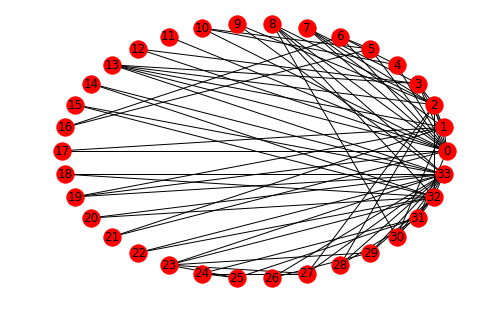

In [3]:
G = nx.karate_club_graph()
#print("Node Degree")
#for v in G:
#    print(f"{v:4} {G.degree(v):6}")

nx.draw_circular(G, with_labels=True)
plt.show()



In [4]:
edge_list = list(G.edges()) 
adj = nx.convert_matrix.to_numpy_matrix(G)

neighbors = dict()
player_numneighbors = dict()
for player in range(G.number_of_nodes()):
  n_list = list(G.neighbors(player))  # neighbor list
  neighbors.update({player: n_list})
  player_numneighbors.update({player: len(n_list)})
  #print(f"{player}: {n_list}")

    
# plt.figure(figsize=[6, 6], dpi=150)
# plt.imshow(adj, cmap='Greys')
# plt.gca().invert_yaxis()
# plt.show()

In [5]:
# sum of 2 = lose -> both get 0 points
# sum of 1 = D wins = #1 wins -> get "b" points > 1 :(
# sum of 0 = both collaborate = get 1 point

def get_points(role, pts_DD=0, pts_DC=1.3, pts_CC=1):
        
  points = np.zeros(G.number_of_nodes())
  for edge in edge_list:
  # edge = list(edge_list[13])
    i, j = edge
    # print(edge)

    role_edge = role[list(edge)]
    sum_edge = sum(role_edge)
    # print(role_edge)
    # print(sum_edge)

    if sum_edge == 0:
      points[i] += pts_CC  # both collaboration
      points[j] += pts_CC
    elif sum_edge == 2:
      points[i] += pts_DD
      points[j] += pts_DD  # both detect
    else:
      if role[i] == 1: # i is bad
        points[i] += pts_DC
      else:            # j is bad
        points[j] += pts_DC
  return points


In [70]:
# Adopt the strategy of whoever is winning of your neighbors
# also look at yourself
def get_new_role(role, neighbors, points_norm, G):
    new_role = np.zeros(len(role))
    for player in range(G.number_of_nodes()):
        n_list = neighbors[player].copy()
        n_list.append(player)
        # n_list = n_list[::-1]  # keep your own role
        n_pts = points_norm[n_list]
        n_roles = role[n_list]
        max_pts = max(n_pts)
        all_winners_index = np.argwhere(n_pts==max_pts).flatten()
        all_winners_players = np.array(n_list)[all_winners_index]
        all_winners_roles = n_roles[all_winners_index]
        # select 1 winner
        # winner = np.random.choice(all_winners_players)
        winner = all_winners_players[0]
        winner_role = role[winner]
        # add randomness 
        new_role[player] = winner_role
    return new_role

def get_new_mutrole(role, neighbors, points_norm, G, p_m = 0, mut_stop = np.inf, round = None):
    if round is not None:
        if round > mut_stop:
            p_m = 0 
    new_role = np.zeros(len(role))
    for player in range(G.number_of_nodes()):
        n_list = neighbors[player].copy()
        n_list.append(player)
        # n_list = n_list[::-1]  # keep your own role
        n_pts = points_norm[n_list]
        n_roles = role[n_list]
        max_pts = max(n_pts)
        all_winners_index = np.argwhere(n_pts==max_pts).flatten()
        all_winners_players = np.array(n_list)[all_winners_index]
        all_winners_roles = n_roles[all_winners_index]
        # select 1 winner
        # winner = np.random.choice(all_winners_players)
        winner = all_winners_players[0]
        winner_role = role[winner]
        # add randomness 
        if np.random.rand() < p_m:
            new_role[player] = (winner_role + 1) % 2
        else:
            new_role[player] = winner_role 
    return new_role

# Make a new function that looks at C vs D when switching to decide whether to sever connection.
# Neil has an interesting suggestion to give people who want to sever a "cooking time" before they
# disconnect someone.

In [71]:
popplayers = nx.algorithms.centrality.degree_centrality(G)
players = np.array(list(popplayers.keys()))
popularity = np.array(list(popplayers.values()))
popular_index = np.argsort(popularity)[::1]




[11]


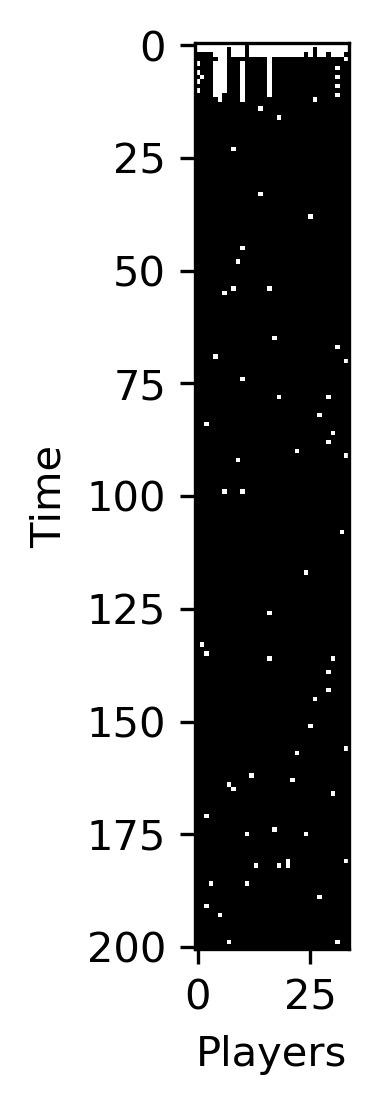

In [88]:
# Build intitial Defector distribution
member_index = list(range(G.number_of_nodes()))
# init_Ds = np.random.choice(member_index, 10, replace=False)
init_Ds = popular_index[0:1]

nx.algorithms.centrality.degree_centrality(G)

role = np.zeros([G.number_of_nodes()])  # 0 = collaborator
print(init_Ds)
role[init_Ds] = 1  # 1 = defector
# print(role)

num_rounds = 200
role_history = np.zeros([num_rounds, G.number_of_nodes()])
for round in range(num_rounds):
  # print(round)
  if round == 0:
    old_role = role.copy()
  else:
    old_role = role_history[round-1, :].copy()
  points = get_points(old_role, pts_DC = 1.3)
  points_norm = points / np.array(list(player_numneighbors.values()))
  # print(points)
  new_role = get_new_mutrole(old_role, neighbors, points_norm, G, p_m = 0.01)
  role_history[round, :] = new_role
   
  # plt.plot(old_role, 'o-')
  # plt.plot(new_role, 'o-')
  # plt.title(f'Round {round}')
  # plt.show()

plt.figure(dpi = 300) 
plt.imshow(np.vstack((role[np.newaxis,:],role_history)), cmap='Greys')
plt.xlabel('Players')
plt.ylabel('Time')
plt.show()
# black is 1